# Predicting the Wind: Data Science in Wind Resource Assessment
**[Florian Roscheck](https://www.linkedin.com/in/florianroscheck/), Data Scientist, EDF Renewables**

2020-03-11, [PyData San Diego Meetup](https://www.meetup.com/PyData-San-Diego/)

<br>
Source Code:

<div style="height:12em"><img src="./images/qr_code_github.png"></div>

[github.com/flrs/predicting_the_wind](https://github.com/flrs/predicting_the_wind)


## Agenda

- What is wind resource assessment?

- Measuring the wind

- Predicting long-term wind speeds

## What is Wind Resource Assessment?

<div style="height:15em"><img src="./images/sandbox_you_are_here.jpg"></div>

<div style="height:18em"><img src="./images/sandbox_build_this_wind_farm.jpg"></div>

<span style="font-size:250%">🤔</span>

**Sounds good, but...**

- How much power is in the wind? 

- Will you be able to sell the generated electricity at a profit?

- A profit over the *next 25 years*?

<span style="font-size:250%">💡</span>

**Wind resource assessment to the rescue!**

- Predict long-term behavior of the wind

- Predict power output of wind turbines

- Know if you will make a profit!

## Wind Resource Assessment = ❤️

- Building models of the physical world is exciting
- Uncertainty is not just a footnote
- Modern data science is relatively new in the field
- Reduce emissions and slow global warming!

## Predicting the Wind: A Data Science Problem!

- Getting wind data
- Cleaning wind data
- Analyzing wind data
- Building a model of the wind
- Predicting the wind and output of the wind farm

## Getting Wind Data: Met Masts

<div style="height:12em"><img src="./images/met_mast.jpg"></div>

**Sensors:** Anemometer (wind speed), wind vane (wind direction), temperature, humidity, precipitation

## Analyzing Wind Data

In [1]:
import pandas as pd

data = pd.read_parquet('./data/met_mast.parquet')

# This mast should only have 2 years of data
data = data['2018-02-01':]

data.round(2).head()

,spd_30,spd_45,spd_58,tmp,dir
time,,,,,
2018-02-01 00:00:00,0.88,1.01,1.08,13.87,115.14
2018-02-01 00:10:00,0.78,0.84,0.91,13.87,100.33
2018-02-01 00:20:00,0.72,0.85,0.92,13.87,101.80
2018-02-01 00:30:00,0.64,0.68,0.72,13.86,125.32
2018-02-01 00:40:00,0.67,0.65,0.68,13.84,157.87


<small>How I got the met mast data: [synthesizing_a_wind_speed_time_series.ipynb](./data_acquisition/synthesizing_a_wind_speed_time_series.ipynb)</small>

**What does wind data look like?**

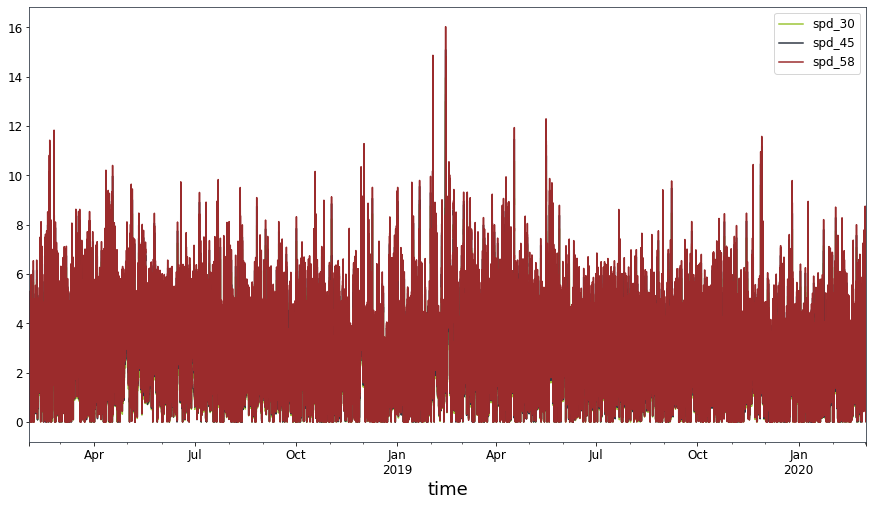

In [2]:
# Plot wind speed time series

import brightwind as bw

anemometers = ['spd_30','spd_45', 'spd_58']
bw.plot_timeseries(data[anemometers])

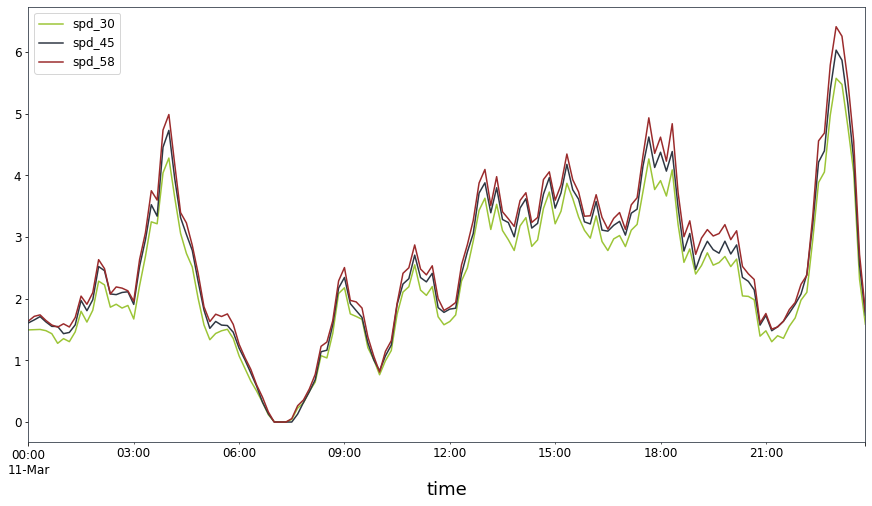

In [3]:
# Plot a less cluttered slice to see height differences

bw.plot_timeseries(data.loc['2019-03-11',anemometers])

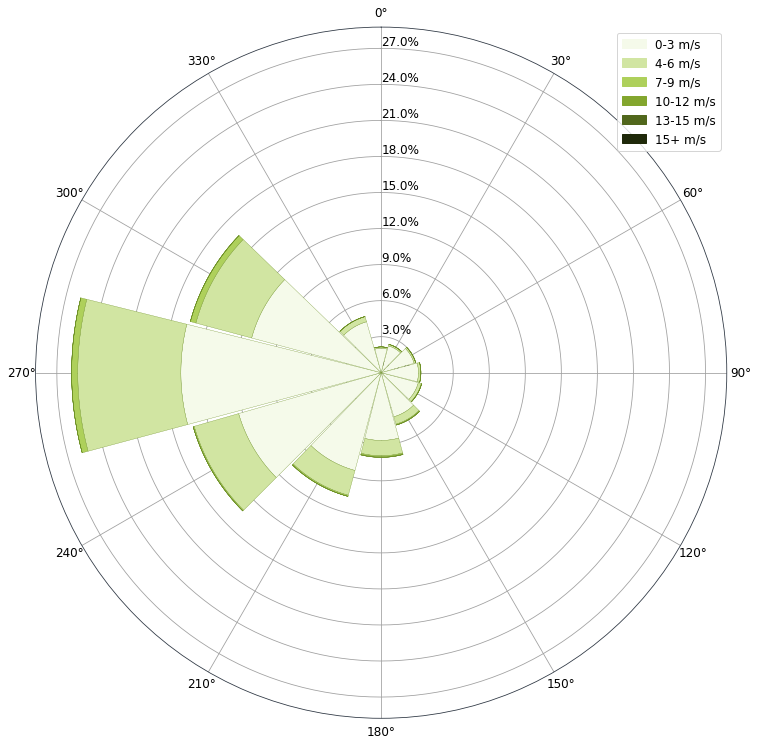

In [4]:
# Plot a frequency rose 🌹

bw.freq_table(data['spd_30'], data['dir'])

## From Measurement to Prediction: Building a Model

- **Problem**: Only 2 years of wind measurement to predict 25 years of wind

- **Solution**: Get more, long-term data!

- **Rationale**: If we know more about the past, we can make better predictions about the future.

### Getting More, Long-Term Data

Popular sources:
- Global climate models
- Other masts

In [5]:
# Draw map of long-term references

import folium 

sandbox_loc = [32.896278, -117.219553]

era5_locs = [[32.95000076293945, -117.30000305175781],
             [32.70000076293945, -117.05000305175781],
             [32.95000076293945, -117.05000305175781],
             [32.70000076293945, -117.30000305175781]]

asos_locs = [[32.8157, -117.1396],
             [32.8645, -117.1366],
             [32.7339, -117.1845]]

m = folium.Map(location=sandbox_loc, tiles='Stamen Terrain', zoom_start = 10)

folium.Marker(sandbox_loc, popup='The Sandbox').add_to(m)

for loc in era5_locs:
    folium.Marker(loc, popup='ERA5', icon=folium.Icon('orange',icon='glyphicon-globe')).add_to(m)

for loc in asos_locs:
    folium.Marker(loc, popup='ASOS', icon=folium.Icon('purple',icon='glyphicon-plane')).add_to(m)
  
m

In [6]:
# Load long-term reference data

from pathlib import Path

lt_data = {'era5_0': 'era5_0.parquet',
           'era5_1': 'era5_1.parquet',
           'MYF': 'MYF_200001010000_202003070000.parquet',
            'NKX': 'NKX_200001010000_202003070000.parquet',
            'SAN': 'SAN_200001010000_202003070000.parquet'}

for name, file in lt_data.items():
    lt_data[name] = pd.read_parquet(Path('./data/').joinpath(file))
    
lt_data['era5_0'].head()

,spd,dir,tmp
time,,,
1999-12-31 16:00:00,4.548827,249.010856,12.370013
1999-12-31 17:00:00,3.981960,251.738388,11.915547
1999-12-31 18:00:00,2.607753,249.791620,11.245783
1999-12-31 19:00:00,1.559933,233.880179,9.782310
1999-12-31 20:00:00,1.359054,231.334928,10.454369


### From Short-Term to Long-Term Data 

We do not fully trust global models and airport mast to predict our met mast. How can we still make them work for us?

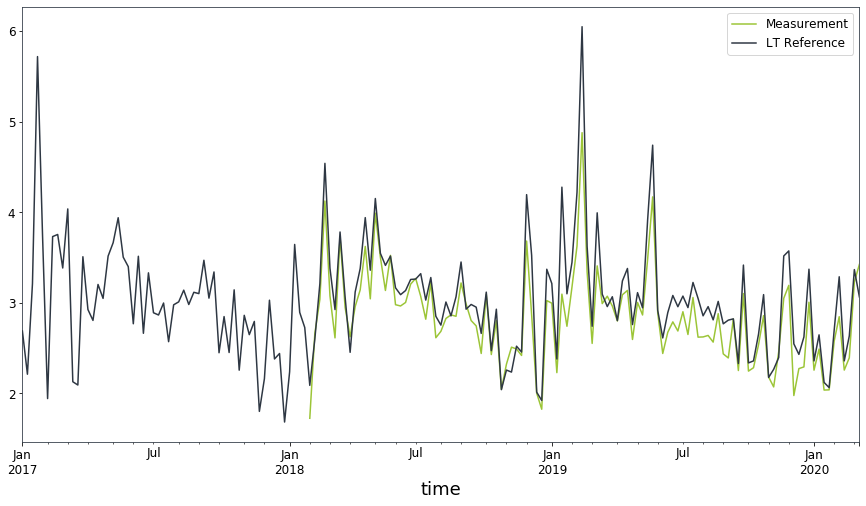

In [7]:
# Show measured vs. long-term reference wind speed data

plot_data = pd.concat(
    [data['spd_58'].resample('1W').mean(), lt_data['era5_0']['spd'].resample('1W').mean()], 
    axis=1)
plot_data.columns = ['Measurement', 'LT Reference']

bw.plot_timeseries(plot_data, date_from='2017')

**Problem**: Measurements different from the references!

**Solution**: 
1. Build model describing relationship between measurement and references
2. Let model predict what long-term measurement would look like

Let's build a model!

### A Simple Model: Orthogonal Least Squares

{'Num data points': 761,
 'offset': 0.48915546304725566,
 'r2': 0.8682745042710436,
 'slope': 0.7728460999482368}


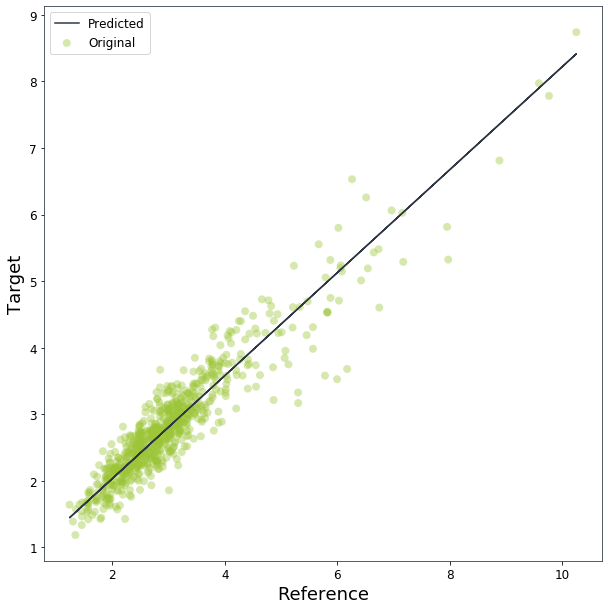

In [8]:
# Build orthogonal least squares model

from brightwind.analyse.correlation import OrthogonalLeastSquares

data_1D = data.resample('1D').mean()
lt_data_1D = lt_data['era5_0'].resample('1D').mean()

ols_model = OrthogonalLeastSquares(ref_spd=lt_data_1D['spd'],
                                   target_spd=data_1D['spd_58'], 
                                   averaging_prd='1D')
ols_model.run()

ols_model.plot()

In [9]:
# Configure scoring metric: RMSE

import numpy as np

def rmse(prediction, actual):
    return np.sqrt(((prediction-actual)**2).mean())

all_predictions = {}
all_scores = {}

In [10]:
# Score simple model

prediction = (ols_model.params['slope']*lt_data_1D['spd']+ols_model.params['offset'])

all_predictions['simple'] = prediction
all_scores['simple'] = rmse(prediction, data_1D['spd_58'])

print('RMSE of simple model: {:.3f}'.format(all_scores['simple']))
print('RMSE as % of wind speed mean: {:.0f}%'.format(all_scores['simple']/data_1D['spd_58'].mean()*100))

RMSE of simple model: 0.315
RMSE as % of wind speed mean: 11%


11% is not really a good number. If our energy prediction is low by 11%, we lose big on this project.

**So: How to improve the model?**

- Also: How do measurements at the met mast relate to measurements at turbine heights?
- Modeling challenges: Topography

### Topography vs. Wind

<img src="./images/shear_over_hill.gif">

**Elevation Map of Area Around the Sandbox**

In [11]:
# Plot elevation map of area around the Sandbox

sandbox_loc = [32.896278, -117.219553]
boundary = (-117.64131499443664,
             32.47993859936589,
             -116.06455693096564,
             33.52096591638937)

m = folium.Map(location=sandbox_loc, tiles='Stamen Toner', zoom_start=14, height=450)

folium.Marker(sandbox_loc, popup='The Sandbox').add_to(m)

m.add_child(
    folium.raster_layers.ImageOverlay(
        str(Path('./data/elev10grd_area_of_interest-min.png').resolve()), 
        opacity=.9, 
        bounds=[[boundary[1], boundary[0]],[boundary[3], boundary[2]]]
    ))

m

**How to take advantage of topographic information?**

Maybe try binning speed by directions?

### A Better Model: Binned Orthogonal Least Squares

In [12]:
# Bin data by direction

dir_bins = pd.IntervalIndex.from_breaks(np.linspace(0,360,13))

data_1D = data.resample('1D').mean()
lt_data_1D = lt_data['era5_0'].resample('1D').mean()

lt_data_1D['dir_bin'] = pd.cut(lt_data_1D['dir'], dir_bins)
data_1D['dir_bin'] = pd.cut(data_1D['dir'], dir_bins)

In [13]:
# Build binned orthogonal least squares model

from scipy.odr import ODR, Model, Data

bin_rmses = []
bin_predictions = []
for dir_bin in dir_bins:
    lt_data_in_bin = lt_data_1D['spd'][lt_data_1D['dir_bin'] == dir_bin]
    data_in_bin = data_1D['spd_58'][data_1D['dir_bin'] == dir_bin]
    
    concurrent_nxs = list(set(lt_data_in_bin.index).intersection(set(data_in_bin.index)))
    
    if not concurrent_nxs:
        continue
    
    def f(B, x):
        return B[0]*x+B[1]
    
    model = ODR(Data(lt_data_in_bin[concurrent_nxs].values, data_in_bin[concurrent_nxs].values), 
                Model(f),
               beta0=[1., 0.5])

    result = model.run()
    
    bin_prediction = f(result.beta, lt_data_in_bin)
    bin_predictions.append(bin_prediction)
    
    bin_rmse = rmse(bin_prediction,data_in_bin)
    bin_rmses.append(bin_rmse)

all_predictions['binned'] = pd.concat(bin_predictions).sort_index()
all_scores['binned'] = np.nanmean(bin_rmses)

print('RMSE of binned model: {:.3f}'.format(all_scores['binned']))

RMSE of binned model: 0.289


### A More Advanced Model: RandomForestRegressor

In [14]:
# Feature engineering

y = data_1D['spd_58']

# Get concurrent time steps
conc_index = set(y.index).intersection(lt_data_1D.index)

X = lt_data_1D.loc[conc_index,['spd', 'dir', 'tmp']]
X = X.sort_index()

# Rolling means (be careful with validation to avoid leakage)
rolling = X['spd'].rolling(3).mean()
rolling = rolling.fillna(rolling.mean())
rolling.name = 'spd_rolling'

X = pd.concat([X, rolling], axis=1)

# Date-based features to capture temporal patterns
X['h'] = lt_data['era5_0'].loc[conc_index,:].index.hour
X['m'] = lt_data['era5_0'].loc[conc_index,:].index.month

X.head()

,spd,dir,tmp,spd_rolling,h,m
time,,,,,,
2018-02-01,1.455543,173.896001,15.397280,3.040377,0,3
2018-02-02,1.528880,168.001625,16.170596,3.040377,0,9
2018-02-03,2.025680,251.970139,16.567941,1.670035,0,8
2018-02-04,1.721126,240.485904,16.587418,1.758562,0,5
2018-02-05,1.847905,235.609613,15.697309,1.864904,0,8


In [15]:
# Build random forest regressor model

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# With holdout data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
hout_model = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=100, min_samples_leaf=10)
hout_model.fit(X_train, y_train)

print('RMSE (CV model, training set): {:.3f}'.format(rmse(hout_model.predict(X_train), y_train)))
print('RMSE (CV model, holdout set): {:.3f}'.format(rmse(hout_model.predict(X_test), y_test)))

# Without holdout data (for fair comparison)
model = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=100, min_samples_leaf=10)
model.fit(X, y)

predictions = hout_model.predict(X)
all_predictions['forest'] = pd.Series(predictions,index=conc_index).sort_index()
all_scores['forest'] = rmse(predictions, y)

print('RMSE (all data model): {:.3f}'.format(all_scores['forest']))

RMSE (CV model, training set): 0.309
RMSE (CV model, holdout set): 0.332
RMSE (all data model): 0.314


### Comparing the 3 Wind Models

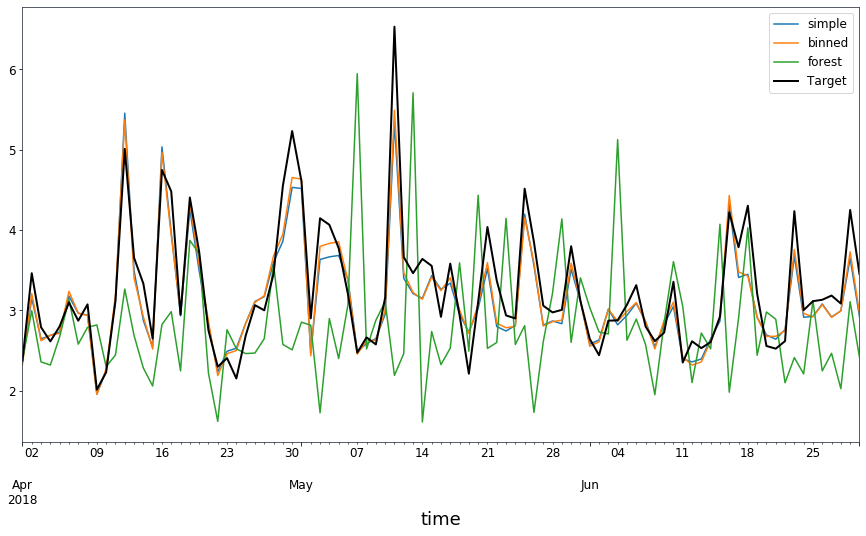

In [16]:
# Plot graphical comparison between models

from matplotlib import pyplot as plt

pd.DataFrame(all_predictions).loc['2018-04':'2018-06',:].plot()
data_1D['spd_58'].loc['2018-04':'2018-06'].plot(c='k',lw=2, label='Target')

plt.legend()
plt.show()

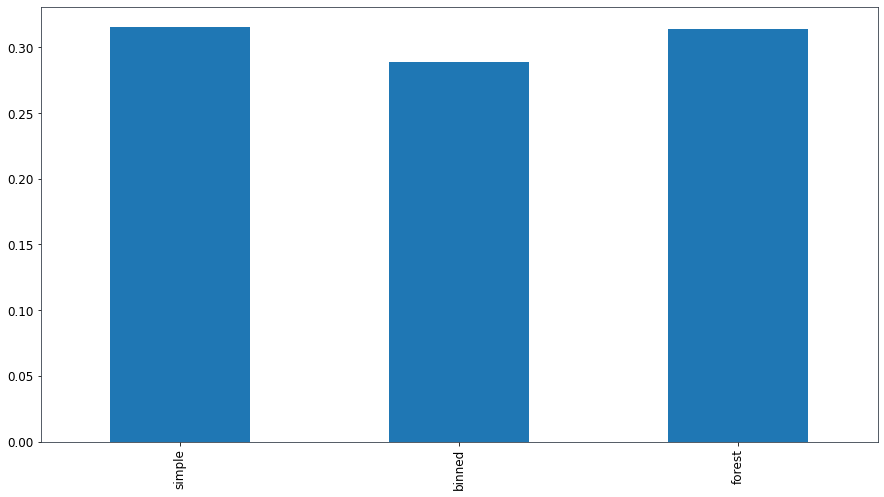

In [17]:
# Plot score comparison

pd.Series(all_scores).plot.bar();

We should use the binned model to predict our long-term wind speed.

## Predicting Energy

Next time or online!

<span style="font-size:250%">🚀</span>

## Internship Opportunity 

Ready to apply machine learning to time series? We are looking for a summer intern!

Apply at [bit.ly/2xsWcln](https://bit.ly/2xsWcln) or scan this code:

<div style="height:30%"><img src="./images/qr_code_internship.png"></div>




## References

**Analyzing Wind Data**
- Met data: [synthesizing_a_wind_speed_time_series.ipynb](./data_acquisition/synthesizing_a_wind_speed_time_series.ipynb)

**Getting Wind Data: Met Masts**
- <a href="https://www.flickr.com/photos/75062596@N00/8104180555">"Wind measurement tower, north of Mobridge, South Dakota"</a> by Lars Plougmann is licensed under <a href="https://creativecommons.org/licenses/by-sa/2.0/?ref=ccsearch&atype=html">CC BY-SA 2.0</a>
- <a href="https://www.flickr.com/photos/37467370@N08/7676229992">"Yiwth_3b"</a> by gvgoebel is licensed under <a href="https://creativecommons.org/licenses/by-sa/2.0/?ref=ccsearch&atype=html">CC BY-SA 2.0</a>

**Getting More, Long-Term Data**
- ASOS data: [download_and_preprocess_asos_data.ipynb](./data_acquisition/download_and_preprocess_asos_data.ipynb)

**Topography vs. Wind**
- Fluid animation comes from this video: https://www.youtube.com/watch?v=-GIToNj-m4M
- Elevation map downloaded from here: http://www.sangis.org/download/index.html